In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2025-07-03 11:56 (eradiate v0.31.0.dev0)*

## Imports

As for all tutorials the first step is to import all necessary classes and create aliases for convenience:

In [2]:
%load_ext eradiate

import eradiate
import matplotlib.pyplot as plt
import numpy as np

eradiate.set_mode("mono")

import eradiate.scenes as ertsc
from eradiate import unit_registry as ureg

Since we will be performing simulations on scenes without an atmosphere, we select the monochromatic (line-by-line) mode. Next, we set up convenience functions for plotting BRF results and visualising camera renders.

In [3]:
def show_camera(
    exp,
    measure_id,
    robust=True,
    add_colorbar=False,
    vmin=None,
    vmax=None,
):
    """
    Display the output of a monochromatic camera measure.
    """
    _, ax = plt.subplots(1,1)
    exp.results[measure_id]["radiance"].squeeze(drop=True).plot.imshow(
        ax=ax,
        origin="upper",
        cmap="Greys_r",
        vmin=vmin,
        vmax=vmax,
        robust=robust,
        add_colorbar=add_colorbar,
    )
    ax.set_aspect(1)
    plt.show()
    plt.close()

def show_brf(exp, measure_id):
    """
    Display the BRF output of a distant radiance measure.
    """
    _, ax = plt.subplots(1,1)
    with plt.style.context({"lines.linestyle": ":", "lines.marker": "."}):
        exp.results[measure_id]["brf"].squeeze(drop=True).plot(ax=ax, x="vza")
    plt.show()
    plt.close()

In [4]:
lambertian_surface=ertsc.surface.BasicSurface(
    shape=ertsc.shapes.RectangleShape(edges=10.0 * ureg.m),
    bsdf=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
)

homogeneous_canopy = ertsc.biosphere.DiscreteCanopy.homogeneous(
    l_vertical=1.0 * ureg.m,
    l_horizontal=10.0 * ureg.m,
    lai=2.0,
    leaf_radius=10 * ureg.cm,
)

Next, we create a perspective camera to visualise the scene:

In [5]:
camera_oblique = ertsc.measure.PerspectiveCameraMeasure(
    id="camera_oblique",
    origin=[15, 15, 15] * ureg.m,
    target=[0, 0, 0] * ureg.m,
    up=[0, 0, 1],
    film_resolution=(320, 240),
    spp=512,
)

In [6]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    canopy=homogeneous_canopy,
    measures=camera_oblique,
)

We run the simulation and use the convenience function defined above to visualise the result.

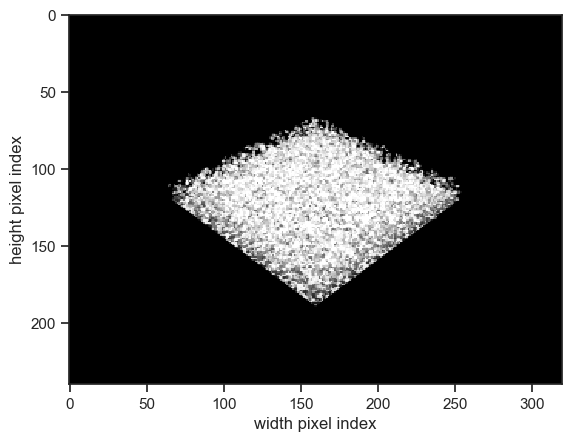

In [7]:
eradiate.run(exp)
show_camera(exp, "camera_oblique")

In [8]:
spherical_leaf_cloud = ertsc.biosphere.LeafCloud.sphere(
    radius = 5.0 * ureg.m,
    n_leaves = 10000,
    leaf_radius = 10.0 * ureg.cm,
    leaf_reflectance=0.5,
    leaf_transmittance=0.5,
)

canopy_sphere = ertsc.biosphere.DiscreteCanopy(
    instanced_canopy_elements=ertsc.biosphere.InstancedCanopyElement(
        id="sphere",
        canopy_element=spherical_leaf_cloud, 
        instance_positions=[(0, 0, 5.0)] * ureg.m
    ),
    size=[10.0, 10.0, 10.0] * ureg.m,
)

Since this canopy has a larger vertical extent, we update our camera parameters so that the canopy fits well within its field of view:

In [9]:
camera_oblique = ertsc.measure.PerspectiveCameraMeasure(
    id="camera_oblique",
    origin=[15, 15, 15] * ureg.m,
    target=[0, 0, 3.0] * ureg.m,
    up=[0, 0, 1],
    film_resolution=(320, 240),
    spp=512,
)

Again, we create an experiment, run it and visualise the results.

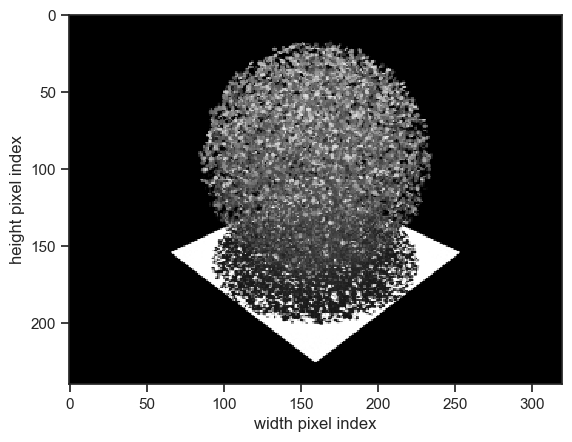

In [10]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.8),
    canopy=canopy_sphere,
    measures=camera_oblique,
)
eradiate.run(exp)
show_camera(exp, "camera_oblique")

In [11]:
fname_cloud = "./tutorial_canopy_definition.txt"

with open(fname_cloud, "w") as outfile:
    for i in range(5000):
        rands = np.random.random(6)
        px = (rands[0] - 0.5) * 2 * 2
        py = (rands[1] - 0.5) * 2 * 2
        pz = (rands[2] - 0.5) * 2 * 2
        
        nx = (rands[3] - 0.5) * 2
        ny = (rands[4] - 0.5) * 2
        nz = (rands[5] - 0.5) * 2
        
        outfile.write(f"0.05 {px} {py} {pz} {nx} {ny} {nz}\n")

The ASCII file for the instance positions simply holds three floating point values per line, which specify the x, y and z coordinates for the instances. Two copies of the leaf cloud positioned diagonally with respect to each other.

In [12]:
fname_instances = "./tutorial_canopy_instances.txt"

with open(fname_instances, "w") as outfile:
    outfile.write("-2.0 2.0 2.0\n")
    outfile.write("2.0 -2.0 2.0\n")

Next, we create a canopy object that uses these definition files:

In [13]:
canopy_files = ertsc.biosphere.DiscreteCanopy.leaf_cloud_from_files(
    id="leaf_cloud",
    leaf_cloud_dicts = [
        {
            "instance_filename": fname_instances,
            "leaf_cloud_filename": fname_cloud,
            "leaf_reflectance": 0.5,
            "leaf_transmittance": 0.5,
            "sub_id": "cube"
        }
    ],
    size=(8, 8, 4)*ureg.m
)

We update the camera and run an experiment to display our canopy:

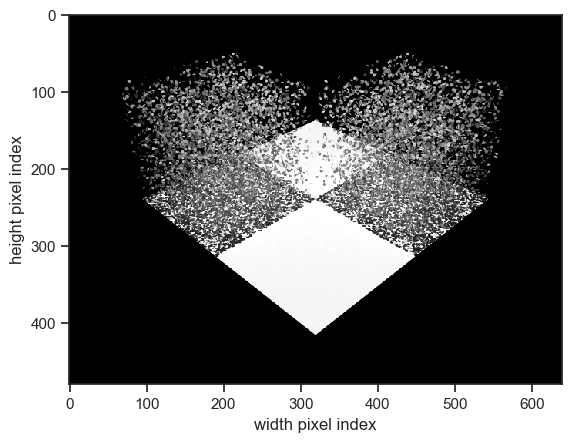

In [14]:
camera_oblique = ertsc.measure.PerspectiveCameraMeasure(
    id="camera_oblique",
    origin=[10, 10, 10] * ureg.m,
    target=[0, 0, 0.0] * ureg.m,
    up=[0, 0, 1],
    film_resolution=(640, 480),
    spp=128,
)

exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.8),
    canopy=canopy_files,
    measures=camera_oblique,
)
eradiate.run(exp)

show_camera(exp, "camera_oblique")